**Оценка кредитного скоринга**


Данные:
У тебя имеются следующие файлы:
– jsons.zip, в котором находится директория jsons. В ней лежат json файлы, каждый из которых представляет собой вызов определенной модели. Известно, что кроме вызовов исследуемой нами модели (под идентификатором 'pd-auto-online'), там лежат и вызовы других моделей.
 

Каждый json имеет следующую структуру: 
 

 {
"requestID": "0000509ba192227041cc6c39035540f7", 
"eventTime": "2024-06-15 00:40:01.483000", 
"loanID": "CC20240615b841",
 "modelID": "pd-cc-online", 
"values": {"pd": 0.1}
}
 

Внутри поля values исследуемой модели находится вложенная структура с полями final_model_score, internal_model_score, external_model_score — значение финального скора, внутреннего скора Альфа-Банка и внешнего скора телекома соответственно.
 

– deal_delqs_logs.pq — выгрузка данных о выходе клиентов в просрочку. Источник имеет следующие поля:
'loan_id' — идентификатор сделки, по которой было зафиксировано событие выхода в просрочку;
‘period_start_date’ — дата начала периода просрочки;
‘period_end_date’ — дата конца периода просрочки. Для случаев, когда сделка всё ещё находится в состоянии дефолта, имеет значение максимально возможной даты

In [28]:
from sklearn.metrics import roc_auc_score
from scipy.stats import norm
import os
import json
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt

Сформируй необходимый набор данных для расчёта метрик: достань все json файлы вызовов исследуемой модели, для каждой заявки (1 вызов = 1 заявка) сформируй флаг выхода в просрочку. Флаг положительный тогда, когда клиент имеет просрочку более 30 дней, которая произошла в период между датой скоринга и датой скоринга плюс 4 месяца. 

Необходимо получить датафрейм, где:

-каждая строка — это один вызов модели pd-auto-online;

-есть скоринговые значения (final_model_score, internal_model_score, external_model_score);

-есть флаг default_flag = 1, если клиент вышел в дефолт в течение 4 месяцев после скоринга.

In [2]:
# Чтение всех JSON
rows = []
for file in os.listdir("Downloads/jsons"):
    if file.endswith(".json"):
        with open(os.path.join("Downloads/jsons", file), "r", encoding="utf-8") as f:
            data = json.load(f)
            if data.get("modelID") == "pd-auto-online":  # фильтруем только нужную модель
                values = data["values"]
                rows.append({
                    "request_id": data["requestID"],
                    "loan_id": data["loanID"],
                    "event_time": pd.to_datetime(data["eventTime"]),
                    "final_model_score": values.get("final_model_score"),
                    "internal_model_score": values.get("internal_model_score"),
                    "external_model_score": values.get("external_model_score")
                })

df_model = pd.DataFrame(rows)
df_model

,request_id,loan_id,event_time,final_model_score,internal_model_score,external_model_score
0,e04f78df44364892aa2c58634b09c837,CAR202406082d96,2024-06-08 05:36:40.410,0.165725,0.19,0.068626
1,e918d6bc8ecdbe93f8e952618a5f04f5,CAR202406249813,2024-06-24 08:53:54.812,0.202490,0.21,0.172448
2,b37b1795180ce014ae65799d8f62b71a,CAR2024020807ff,2024-02-08 12:38:03.628,0.018751,0.01,0.053757
3,d4360cb2580400bfe899d83075a16e65,CAR2024060662da,2024-06-06 04:54:40.222,0.197604,0.22,0.108022
4,3e3ef7fd9a46df82bf08200c8153787b,CAR202405145016,2024-05-14 16:39:32.368,0.057011,0.06,0.045055
...,...,...,...,...,...,...
51703,f6bb4ae13f33fa7fc9a4021da8960327,CAR2024020509a8,2024-02-05 12:21:23.907,0.028676,0.02,0.063380
51704,92b6ca703d5f98ab03ae4686952f58d5,CAR2024011848d4,2024-01-18 00:49:13.545,NaN,NaN,0.081337
51705,7203f0d03da04c16f9893c8588eee1ca,CAR202404294b86,2024-04-29 19:38:53.022,0.052706,0.05,0.063532
51706,2d590c82f872754ee3a24cdc7b7802de,CAR2024050622fb,2024-05-06 19:20:08.443,0.027051,0.01,0.095257


In [3]:
#Загрузка данных о просрочках
df_delq = pd.read_parquet("Downloads/deal_delqs_logs.pq")
df_delq["period_start_date"] = pd.to_datetime(df_delq["period_start_date"])
df_delq["period_end_date"] = pd.to_datetime(df_delq["period_end_date"])

Определение дефолта для каждой заявки

Условие:

-просрочка длиной ≥ 30 дней (period_end_date - period_start_date >= 30 дней);

-просрочка началась в течение 4 месяцев после скоринга.

In [4]:
def check_default(loan_id, scoring_date):
    subset = df_delq[df_delq["loan_id"] == loan_id]
    if subset.empty:
        return 0
    horizon_end = scoring_date + pd.DateOffset(months=4)
    for _, row in subset.iterrows():
        delay = (row["period_end_date"] - row["period_start_date"]).days
        if delay >= 30 and (scoring_date <= row["period_start_date"] <= horizon_end):
            return 1
    return 0

df_model["default_flag"] = df_model.apply(
    lambda row: check_default(row["loan_id"], row["event_time"]), axis=1
)
df_model.head()

,request_id,loan_id,event_time,final_model_score,internal_model_score,external_model_score,default_flag
0,e04f78df44364892aa2c58634b09c837,CAR202406082d96,2024-06-08 05:36:40.410,0.165725,0.19,0.068626,0
1,e918d6bc8ecdbe93f8e952618a5f04f5,CAR202406249813,2024-06-24 08:53:54.812,0.202490,0.21,0.172448,0
2,b37b1795180ce014ae65799d8f62b71a,CAR2024020807ff,2024-02-08 12:38:03.628,0.018751,0.01,0.053757,0
3,d4360cb2580400bfe899d83075a16e65,CAR2024060662da,2024-06-06 04:54:40.222,0.197604,0.22,0.108022,0
4,3e3ef7fd9a46df82bf08200c8153787b,CAR202405145016,2024-05-14 16:39:32.368,0.057011,0.06,0.045055,0


Динамика Gini для каждого из скоров по месячным срезам (под срезом понимается множество вызовов моделей, относящихся к одному месяцу);

In [35]:
df_model["event_time"] = pd.to_datetime(df_model["event_time"])
df_model["month"] = df_model["event_time"].dt.to_period("M").dt.to_timestamp()
df_model = df_model.dropna(subset=["final_model_score"])
df_model.head()

,request_id,loan_id,event_time,final_model_score,internal_model_score,external_model_score,default_flag,month
0,e04f78df44364892aa2c58634b09c837,CAR202406082d96,2024-06-08 05:36:40.410,0.165725,0.19,0.068626,0,2024-06-01
1,e918d6bc8ecdbe93f8e952618a5f04f5,CAR202406249813,2024-06-24 08:53:54.812,0.202490,0.21,0.172448,0,2024-06-01
2,b37b1795180ce014ae65799d8f62b71a,CAR2024020807ff,2024-02-08 12:38:03.628,0.018751,0.01,0.053757,0,2024-02-01
3,d4360cb2580400bfe899d83075a16e65,CAR2024060662da,2024-06-06 04:54:40.222,0.197604,0.22,0.108022,0,2024-06-01
4,3e3ef7fd9a46df82bf08200c8153787b,CAR202405145016,2024-05-14 16:39:32.368,0.057011,0.06,0.045055,0,2024-05-01


In [36]:
def safe_gini(y_true: np.ndarray, y_score: np.ndarray) -> float:
    """
    Gini = 2*AUC - 1, безопасный расчёт:
    - Если во фрагменте нет и 0 и 1 (или мало наблюдений), возвращаем np.nan
    """
    y_true = np.asarray(y_true)
    y_score = np.asarray(y_score)
    # Нужны и дефолты, и недефолты
    uniq = np.unique(y_true)
    if len(uniq) < 2:
        return np.nan
    try:
        auc = roc_auc_score(y_true, y_score)
        return 2 * auc - 1
    except Exception:
        return np.nan

In [37]:
# Динамика Gini по месячным срезам для каждого скора
def gini_by_month(df: pd.DataFrame, score_col: str) -> pd.DataFrame:
    out = (df
           .groupby("month", as_index=False)
           .apply(lambda g: pd.Series({
               "gini": safe_gini(g["default_flag"].values, g[score_col].values),
               "n": len(g)
           }), include_groups=False)
           .reset_index(drop=True))
    out["score"] = score_col
    return out[["month", "score", "gini", "n"]]

gini_final    = gini_by_month(df_model, "final_model_score")
gini_internal = gini_by_month(df_model, "internal_model_score")
gini_external = gini_by_month(df_model, "external_model_score")

gini_all = pd.concat([gini_final, gini_internal, gini_external], ignore_index=True).sort_values(["month","score"])
print(gini_all.to_string(index=False))

     month                score     gini      n
2024-01-01 external_model_score 0.268865 8366.0
2024-01-01    final_model_score 0.505326 8366.0
2024-01-01 internal_model_score 0.476789 8366.0
2024-02-01 external_model_score 0.217907 7813.0
2024-02-01    final_model_score 0.495358 7813.0
2024-02-01 internal_model_score 0.482287 7813.0
2024-03-01 external_model_score 0.242727 8460.0
2024-03-01    final_model_score 0.495311 8460.0
2024-03-01 internal_model_score 0.472437 8460.0
2024-04-01 external_model_score 0.210825 8131.0
2024-04-01    final_model_score 0.471593 8131.0
2024-04-01 internal_model_score 0.453865 8131.0
2024-05-01 external_model_score 0.193022 8435.0
2024-05-01    final_model_score 0.498285 8435.0
2024-05-01 internal_model_score 0.496403 8435.0
2024-06-01 external_model_score 0.197033 7924.0
2024-06-01    final_model_score 0.491538 7924.0
2024-06-01 internal_model_score 0.473317 7924.0


Для финального скора дополнительно построить помесячную динамику границ 95% доверительного интервала с использованием бутстрепа (для каждого месячного среза выполняем 1000 итераций с выбором 70% случайных записей); 

In [38]:
def bootstrap_ci_gini(y_true, y_score, n_iter=1000, frac=0.7, random_state=42):
    """Бутстреп 95% ДИ Gini"""
    rng = np.random.default_rng(random_state)
    n = len(y_true)
    m = int(frac * n)
    ginis = []
    for _ in range(n_iter):
        idx = rng.choice(n, size=m, replace=False)
        g = safe_gini(y_true[idx], y_score[idx])
        if not np.isnan(g):
            ginis.append(g)
    if len(ginis) == 0:
        return np.nan, np.nan, np.nan
    mean_g = np.mean(ginis)
    ci_low = np.percentile(ginis, 2.5)
    ci_high = np.percentile(ginis, 97.5)
    return mean_g, ci_low, ci_high

In [39]:
results = []
for month, group in df_model.groupby("month"):
    mean_g, low, high = bootstrap_ci_gini(group["default_flag"].values,
                                          group["final_model_score"].values,
                                          n_iter=1000, frac=0.7)
    results.append({"month": month, "gini_mean": mean_g, "ci_low": low, "ci_high": high, "n": len(group)})

df_ci = pd.DataFrame(results).sort_values("month")

print(df_ci)

       month  gini_mean    ci_low   ci_high     n
0 2024-01-01   0.505576  0.480597  0.531186  8366
1 2024-02-01   0.495253  0.466208  0.525679  7813
2 2024-03-01   0.495964  0.468292  0.522413  8460
3 2024-04-01   0.471791  0.443928  0.501228  8131
4 2024-05-01   0.497658  0.471079  0.524898  8435
5 2024-06-01   0.491809  0.463572  0.517088  7924


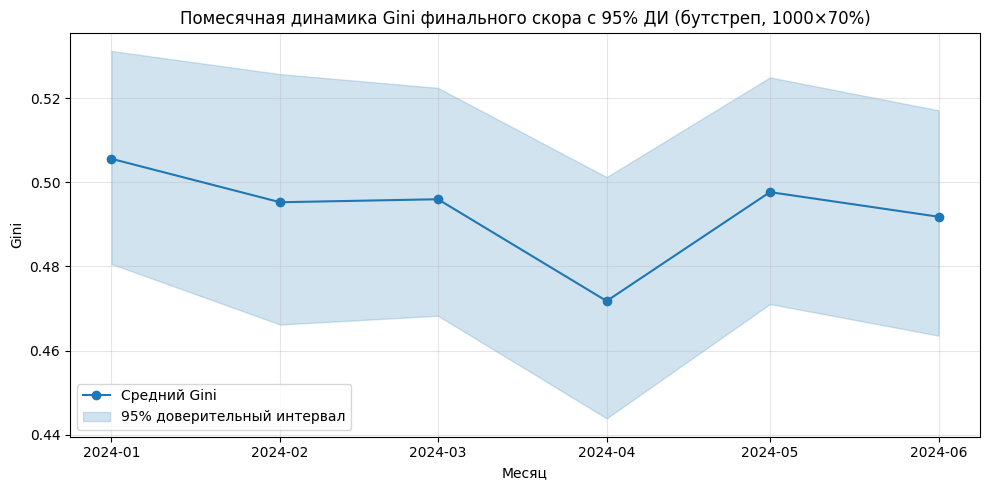

In [40]:
plt.figure(figsize=(10,5))
plt.plot(df_ci["month"], df_ci["gini_mean"], label="Средний Gini", color="tab:blue", marker="o")
plt.fill_between(df_ci["month"], df_ci["ci_low"], df_ci["ci_high"],
                 color="tab:blue", alpha=0.2, label="95% доверительный интервал")

plt.title("Помесячная динамика Gini финального скора с 95% ДИ (бутстреп, 1000×70%)")
plt.xlabel("Месяц")
plt.ylabel("Gini")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

Аплифт от использования внешнего скора: найти разницу между значениями Gini финального и внутреннего скора на каждый месячный срез.


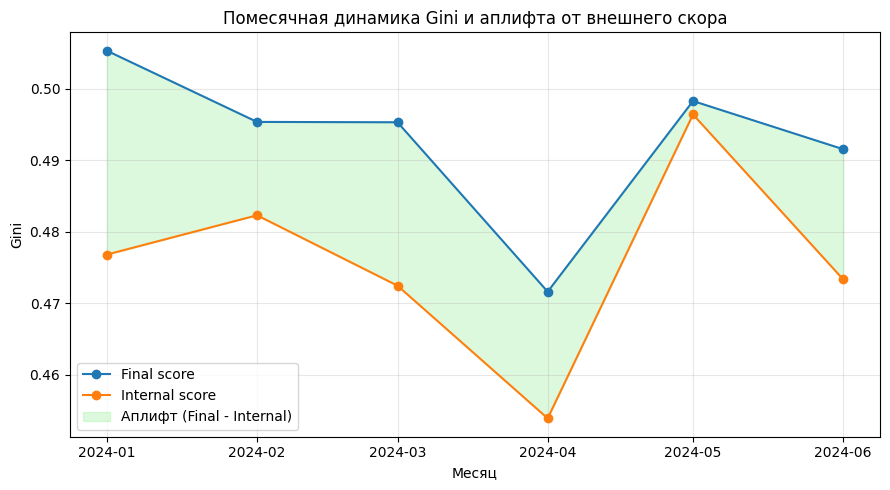

In [44]:
plt.figure(figsize=(9,5))
plt.plot(df_uplift["month"], df_uplift["gini_final"], label="Final score", marker="o")
plt.plot(df_uplift["month"], df_uplift["gini_internal"], label="Internal score", marker="o")
plt.fill_between(df_uplift["month"],
                 df_uplift["gini_internal"],
                 df_uplift["gini_final"],
                 color="lightgreen", alpha=0.3, label="Аплифт (Final - Internal)")
plt.title("Помесячная динамика Gini и аплифта от внешнего скора")
plt.xlabel("Месяц")
plt.ylabel("Gini")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [43]:
#Расчёт Gini по месяцам для финального и внутреннего скорингов ---
gini_by_month = []
for month, group in df_model.groupby("month"):
    gini_final = safe_gini(group["default_flag"].values, group["final_model_score"].values)
    gini_internal = safe_gini(group["default_flag"].values, group["internal_model_score"].values)
    uplift = gini_final - gini_internal if not (np.isnan(gini_final) or np.isnan(gini_internal)) else np.nan
    gini_by_month.append({
        "month": month,
        "gini_final": gini_final,
        "gini_internal": gini_internal,
        "uplift_final_minus_internal": uplift,
        "n": len(group)
    })

df_uplift = pd.DataFrame(gini_by_month).sort_values("month")
print(df_uplift)

       month  gini_final  gini_internal  uplift_final_minus_internal     n
0 2024-01-01    0.505326       0.476789                     0.028536  8366
1 2024-02-01    0.495358       0.482287                     0.013071  7813
2 2024-03-01    0.495311       0.472437                     0.022874  8460
3 2024-04-01    0.471593       0.453865                     0.017728  8131
4 2024-05-01    0.498285       0.496403                     0.001882  8435
5 2024-06-01    0.491538       0.473317                     0.018221  7924


## Анализ динамики Gini и аплифта от внешнего скора

### 1. Аплифт от использования внешнего скора
На графике видно, что значение **Gini финального скора (Final score)** во всех месяцах выше, чем у **внутреннего скора (Internal score)**.  
Разница между ними (зеленая область) показывает **положительный аплифт**.

**Основные наблюдения:**
- Во всех месяцах 2024 года аплифт положительный.  
- Средний прирост составляет **около +1–3 п.п.**  
- Максимальный эффект наблюдается в апреле–мае (до **+3–4 п.п.**).  

**Вывод:**  
Использование внешнего скора оправдано — он стабильно повышает качество ранжирования клиентов.  
Даже умеренный аплифт в несколько пунктов Gini при больших портфелях имеет практическую ценность для риск-моделирования и стратегии скоринга.

---

### 2. Качество ранжирования финального скора 
На втором графике показана динамика Gini финального скора с 95% доверительными интервалами, рассчитанными методом бутстрепа (1000 итераций, 70% выборки).

**Наблюдения:**
- Средние значения Gini находятся в диапазоне **0.47–0.51**.  
- Нижняя граница доверительного интервала не опускается ниже **0.45**, верхняя достигает **0.52–0.53**.  
- Среднее значение Gini за весь период ≈ **0.49–0.50 (49–50 п.п.)**.

**Вывод:**  
Финальный скор находится **на верхней границе жёлтой зоны**, близко к «зелёному» уровню.  
Это означает, что модель **достаточно хорошо различает клиентов по риску**, демонстрируя устойчивое качество ранжирования и стабильность по времени.

